### Imports 

In [1]:
#for dealing with data:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import xarray as xr

#for dealing with files:
import os
import re
from scipy.io import readsav
import h5py
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
from urllib.parse import urljoin, urlparse
import time

#for plotting (the rcParams updates are my personal perference to change font and increase fontsize)
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 24,\
                     'xtick.labelsize' : 24,\
                     'ytick.labelsize' : 24,\
                     'axes.titlesize' : 24,\
                     'axes.labelsize' : 24,\
                     'date.autoformatter.minute': '%H:%M' })

# all helper functions for downloading and parsing data
import skymap_data_helper

# for contrast adjustment
import cv2

# for resolution increase
from PIL import Image

import importlib
importlib.reload(skymap_data_helper)

import math

import importlib
importlib.reload(skymap_data_helper)



#data_yknf = readsav("./trex-rgb-asi_data/rgb_skymap_yknf_20240829-%2B_v01.sav", verbose=False)['skymap']
#data_fsmi = readsav("./trex-rgb-asi_data/rgb_skymap_fsmi_20240808-%2B_v01.sav", verbose=False)['skymap']




<module 'skymap_data_helper' from '/home/molidae/Desktop/berkeley/ssl/skymap_data_helper.py'>

### Loading Data

In [2]:
#load an hour of data
site_yknf = 'yknf'
site_fsmi = 'fsmi'
date = datetime(2024,8,30)
hour = 5 #this is in UT

rgb_asi_skymap_lookup_df = skymap_data_helper.build_rgb_asi_skymap_lookup_table(directory='./trex-rgb-asi_data') #CHANGE TO YOUR SKYMAP DIRECTORY!
yknf_rgb_asi_ds = skymap_data_helper.load_rgb_asi_hour_to_xarray(site_yknf, date, hour, rgb_asi_skymap_lookup_df,data_dir='./trex-rgb-asi_data', skymap_dir='./trex-rgb-asi_data') #CHANGE DIRECTORIES!
fsmi_rgb_asi_ds = skymap_data_helper.load_rgb_asi_hour_to_xarray(site_fsmi, date, hour, rgb_asi_skymap_lookup_df,data_dir='./trex-rgb-asi_data', skymap_dir='./trex-rgb-asi_data') #CHANGE DIRECTORIES!


Skymap file:
rgb_skymap_yknf_20240829-%2B_v01.sav
skymap path:
./trex-rgb-asi_data/rgb_skymap_yknf_20240829-%2B_v01.sav
Skymap file:
rgb_skymap_fsmi_20240808-%2B_v01.sav
skymap path:
./trex-rgb-asi_data/rgb_skymap_fsmi_20240808-%2B_v01.sav


### Projecting pixels to some lat/lon

In [3]:
def project_lat_lon(az_arr, el_arr, lat_camera, lon_camera, h):
    '''
    params: 
    az_arr = 2D azimuth array for each pixel (NaNs ok, degrees, xarray)
    el_arr = 2D elevation array for each pixel (NaNs ok, degrees, xarray)
    lat_camera = latitude of camera (degrees)
    lon_camera = longitude of camera (degrees)
    h = height you want to project azimuth and elevation to to get latitude and longitude for each pixel

    returns: 
    lat_aurora_arr = latitudes of the aurora projected to given height h
    lon_aurora_arr = longitudes of the aurora project to give height h 
    '''

    # convert to radians 
    az_arr = np.radians(np.array(az_arr))
    el_arr = np.radians(np.array(el_arr))

    # Sanity check
    # print(f"Az: {az_arr.shape}")
    # print(f"El: {el_arr.shape}")

    
    
    # horizontal distance between camera and aurora along camera's tangent plane
    d1_arr = h / np.tan(el_arr)

    # decompose horizontal distance into east and north components relative to camera tan plane
    dx_arr = d1_arr * np.sin(az_arr)
    dy_arr = d1_arr * np.cos(az_arr)

    # convert N/E offset components to (lat, lon) --> comes out in decimal degrees 
    lat_delta_arr = dx_arr / 111045 #degrees
    lon_delta_arr = dy_arr / (np.cos(np.radians(lat_camera + lat_delta_arr)) * 111321) 

    # add lat/long offset to camera's og lat/lon to get the lat/lon of the aurora at the chosen height!
    lat_aurora_arr = lat_camera + lat_delta_arr
    lon_aurora_arr = lon_camera + lon_delta_arr

    # print(f"lat proj: {lat_aurora_arr.shape}")
    # print(f"lon proj: {lon_aurora_arr.shape}")

    return lat_aurora_arr, lon_aurora_arr

In [4]:
h_target = 110000 
lat_yknf = yknf_rgb_asi_ds.attrs["site_latitude"]
lon_yknf = yknf_rgb_asi_ds.attrs["site_longitude"]
full_elevation_yknf = yknf_rgb_asi_ds["elevation"]
full_azimuth_yknf = yknf_rgb_asi_ds["azimuth"]

lat_proj_110_arr, lon_proj_110_arr = project_lat_lon(full_azimuth_yknf, 
                                                 full_elevation_yknf,
                                                 lat_yknf,
                                                 lon_yknf,
                                                 h_target
                                                )


    # ds_all.attrs["site_latitude"] = skymap["site_lat"]
    # ds_all.attrs["site_longitude"] = skymap["site_lon"]
    # ds_all.attrs["site_altitude_m"] = skymap["site_alt"]
    # ds_all.attrs["skymap_file"] = skymap_file

    # ds_all["elevation"] = (("x", "y"), skymap["elevation"])
    # ds_all["azimuth"] = (("x", "y"), skymap["azimuth"])
    # ds_all["lat_110"] = (("x", "y"), skymap["map_latitude"][1,1:,1:])
    # ds_all["lon_110"] = (("x", "y"), skymap["map_longitude"][1,1:,1:])


In [5]:
lat_110_arr = np.array(yknf_rgb_asi_ds["lat_110"])
lon_110_arr = np.array(yknf_rgb_asi_ds["lon_110"])

print(f"lat 110: {lat_110_arr.shape}")
print(f"lon 110: {lon_110_arr.shape}")

lat 110: (480, 553)
lon 110: (480, 553)


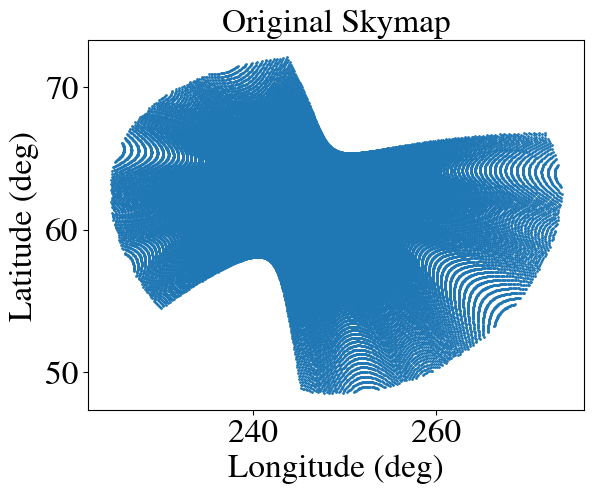

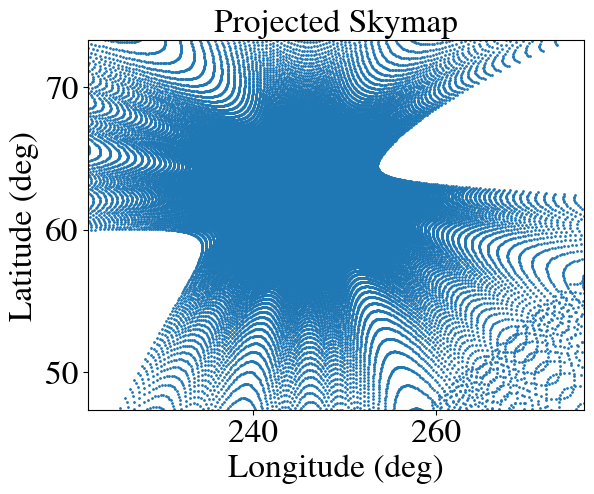

In [6]:
# original skymap
plt.figure()
plt.scatter(lon_110_arr.flatten(), lat_110_arr.flatten(), s=1, label="True Skymap")
#plt.legend()
plt.xlabel("Longitude (deg)")
plt.ylabel("Latitude (deg)")
plt.title("Original Skymap")
# plt.xlim(45, 75)
# plt.ylim(230, 270)
ax_skymap = plt.gca()
# print("X-axis limits:", ax.get_xlim())
# print("Y-axis limits:", ax.get_ylim())
plt.show()

# projected skymap
plt.figure()
plt.scatter(lon_proj_110_arr.flatten(), lat_proj_110_arr.flatten(), s=1, label="Projected to 110")
#plt.legend()
plt.xlabel("Longitude (deg)")
plt.ylabel("Latitude (deg)")
plt.title("Projected Skymap")
plt.xlim(ax_skymap.get_xlim())
plt.ylim(ax_skymap.get_ylim())
plt.show()


### Overlaid Graph

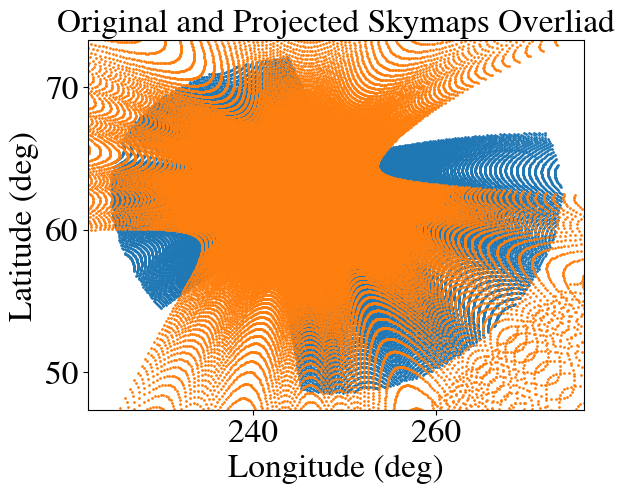

In [7]:
# original skymap
plt.figure()
plt.scatter(lon_110_arr.flatten(), lat_110_arr.flatten(), s=1, label="True Skymap")
plt.scatter(lon_proj_110_arr.flatten(), lat_proj_110_arr.flatten(), s=1, label="Projected to 110")

plt.xlabel("Longitude (deg)")
plt.ylabel("Latitude (deg)")
plt.title("Original and Projected Skymaps Overliad")
plt.xlim(ax_skymap.get_xlim())
plt.ylim(ax_skymap.get_ylim())
plt.show()

# check azimuth, elevation cutoff (mine is not restricted) 
# look at individual pixels near the center --> check rotation 
# static num for latitude error 

### Overlaying Pixels -- Difference between skymap and my projection
- try one frame
- try averaging a few frames --> do time slices over the entire hour

(480, 553, 3)


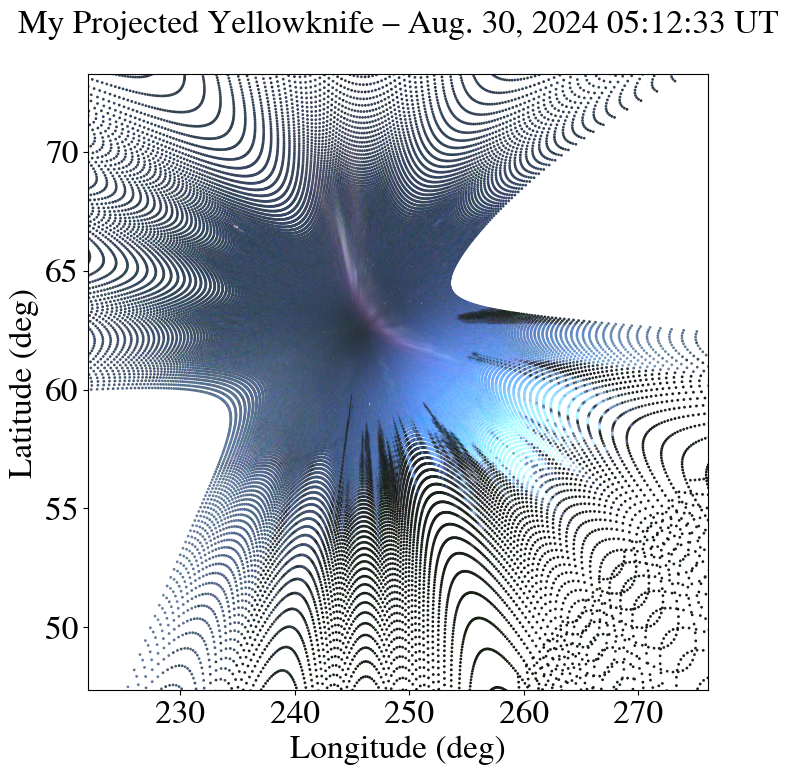

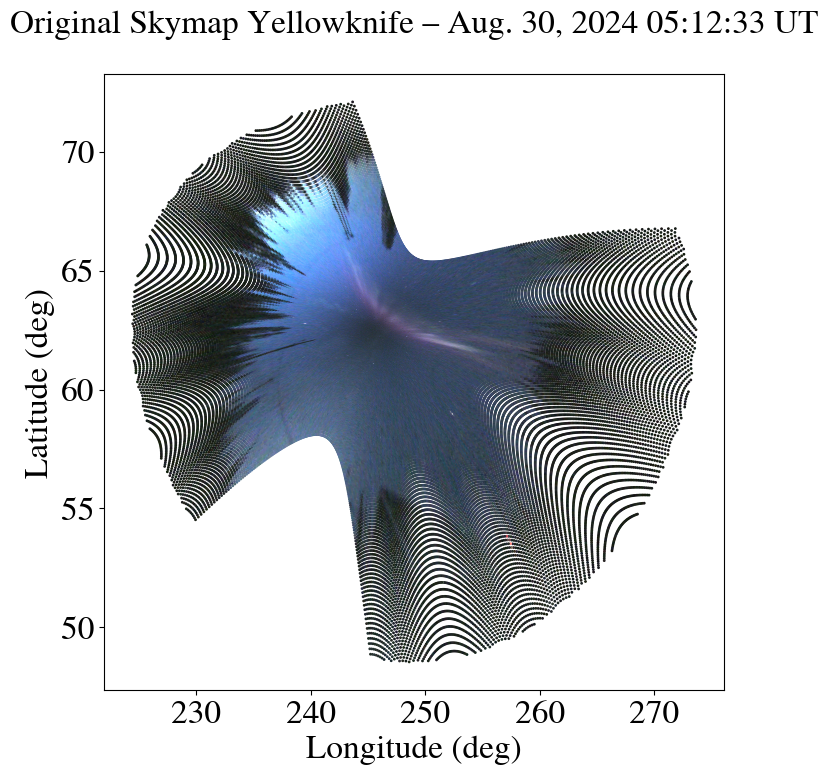

In [8]:
time_index = 251 # look at 5:10 UTC

R = yknf_rgb_asi_ds.image.sel(channel="R").isel(times=time_index).values
G = yknf_rgb_asi_ds.image.sel(channel="G").isel(times=time_index).values
B = yknf_rgb_asi_ds.image.sel(channel="B").isel(times=time_index).values
#RGB = yknf_rgb_asi_ds.image.isel(times=time_index).values

# Extract time and format it
raw_time = yknf_rgb_asi_ds.times.values[time_index]
time_obj = pd.to_datetime(raw_time.decode("utf-8").replace(" UTC", ""))
time_str = time_obj.strftime("%b. %d, %Y %H:%M:%S UT")

# Site label - can adjust to allow for different sites!
site_name_yknf = "Yellowknife" ## CHANGE FOR DIFF SITE
site_name_yknf_short = "yknf" ## CHANGE FOR DIFF SITE

# contrast adjustment: alpha=contrast, beta=brightness
alpha = 5
beta = 5
rgb = np.stack([R, G, B], axis=-1)  # shape: (x, y, 3)
rgb_yknf_adjusted = cv2.convertScaleAbs(rgb, alpha=alpha, beta=beta)
print(rgb_yknf_adjusted.shape)

# yknf projected
fig1, ax1 = plt.subplots(figsize=(8,8))
scat = ax1.scatter(lon_proj_110_arr.flatten(),lat_proj_110_arr.flatten(),c=rgb_yknf_adjusted.reshape(-1, 3)/256,s=1)
plt.xlim(ax_skymap.get_xlim())
plt.ylim(ax_skymap.get_ylim())
ax1.set_ylabel("Latitude (deg)")
ax1.set_xlabel("Longitude (deg)")
ax1.set_title(f"My Projected {site_name_yknf} – {time_str}", pad=30);
plt.show()

# yknf given skymap
fig2, ax2 = plt.subplots(figsize=(8,8))
scat = ax2.scatter(lon_110_arr.flatten(),lat_110_arr.flatten(),c=rgb_yknf_adjusted.reshape(-1, 3)/256,s=1)
plt.xlim(ax_skymap.get_xlim())
plt.ylim(ax_skymap.get_ylim())
ax2.set_ylabel("Latitude (deg)")
ax2.set_xlabel("Longitude (deg)")
ax2.set_title(f"Original Skymap {site_name_yknf} – {time_str}", pad=30);
plt.show()


### Error Calculations
- difference between the true skymaps and my projected skymaps
- can't do this bc my projections based on el/az, which has diff shape than the lat110/lon110 given in the skymap

In [9]:
# # remove NaNs
# lat_mask_true_skymap = ~np.isnan(lat_110_arr) 
# lat_mask_proj_skymap = ~np.isnan(lat_proj_110_arr)
# lon_mask_true_skymap = ~np.isnan(lat_110_arr) 
# lon_mask_proj_skymap = ~np.isnan(lat_proj_110_arr) 

# combined_mask = lat_mask_true_skymap & lat_mask_proj_skymap

# lat_110_arr_masked = np.array(np.where(lat_mask_true_skymap & lat_mask_proj_skymap))
# lat_proj_110_arr_masked = np.array(np.where(lat_mask_true_skymap & lat_mask_proj_skymap))
# lon_110_arr_masked = np.array(np.where(lon_mask_true_skymap & lon_mask_proj_skymap))
# lon_proj_110_arr_masked = np.array(np.where(lon_mask_true_skymap & lon_mask_proj_skymap))


# # get difference in distance, m (hence scaling) 
# north_err = (lat_proj_110_arr_masked - lat_110_arr_masked) * 111045
# east_err = (lon_proj_110_arr_masked - lon_110_arr_masked) * np.cos(np.radians(lat_proj_110_arr_masked)) * 111321

# total_err = np.sqrt(north_err**2, east_err**2) # array of per-pix error
# print(total_err)

# mean_err = np.mean(total_err)
# rms_err = np.sqrt(np.mean(total_err**2))
# max_err = np.max(total_err)

# print(f"Mean error: {mean_err:.1f} m")
# print(f"RMS error:  {rms_err:.1f} m")
# print(f"Max error:  {max_err:.1f} m")

### 110km Projected Comparisons b/w YKNF and FSMI

In [10]:
h_target = 110000 

lat_yknf = yknf_rgb_asi_ds.attrs["site_latitude"]
lon_yknf = yknf_rgb_asi_ds.attrs["site_longitude"]
full_elevation_yknf = yknf_rgb_asi_ds["elevation"]
full_azimuth_yknf = yknf_rgb_asi_ds["azimuth"]

lat_fsmi = fsmi_rgb_asi_ds.attrs["site_latitude"]
lon_fsmi = fsmi_rgb_asi_ds.attrs["site_longitude"]
full_elevation_fsmi = fsmi_rgb_asi_ds["elevation"]
full_azimuth_fsmi = fsmi_rgb_asi_ds["azimuth"]

yknf_lat_proj_110_arr, yknf_lon_proj_110_arr = project_lat_lon(full_azimuth_yknf, 
                                                 full_elevation_yknf,
                                                 lat_yknf,
                                                 lon_yknf,
                                                 h_target
                                                )

fsmi_lat_proj_110_arr, fsmi_lon_proj_110_arr = project_lat_lon(full_azimuth_fsmi, 
                                                 full_elevation_fsmi,
                                                 lat_fsmi,
                                                 lon_fsmi,
                                                 h_target
                                                )

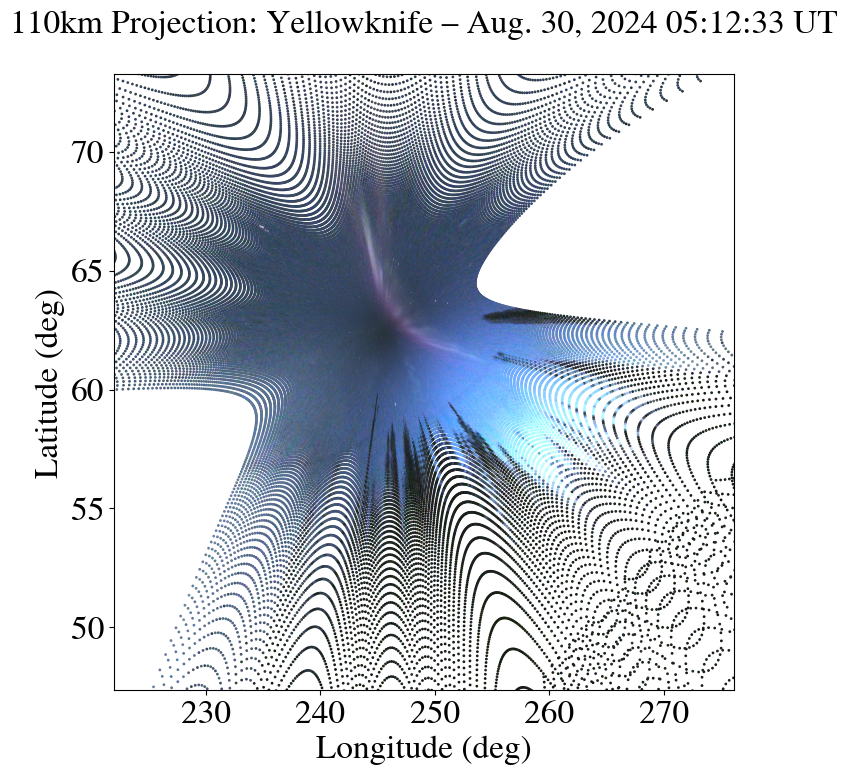

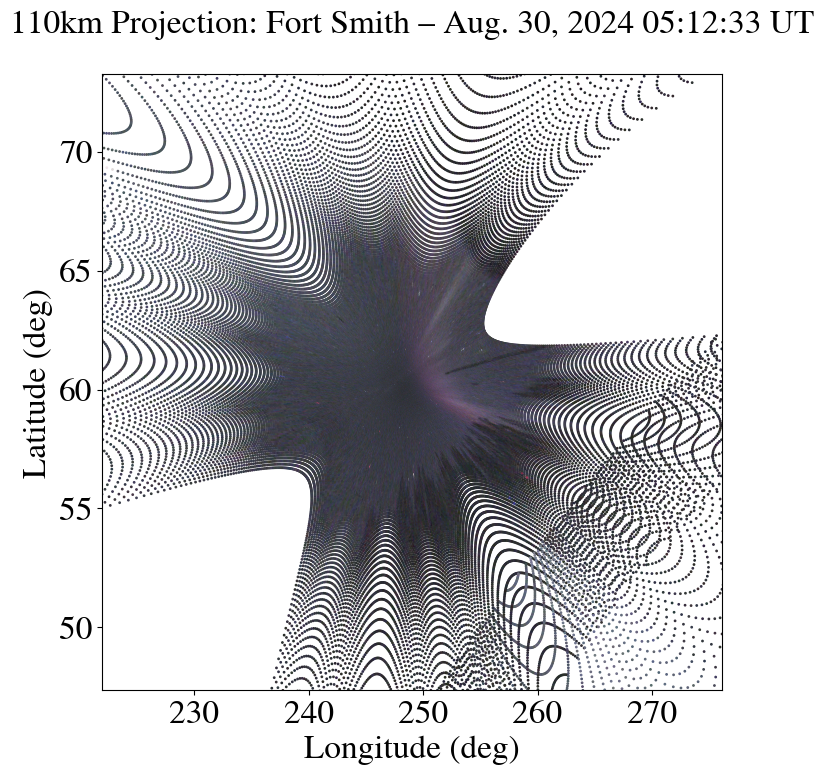

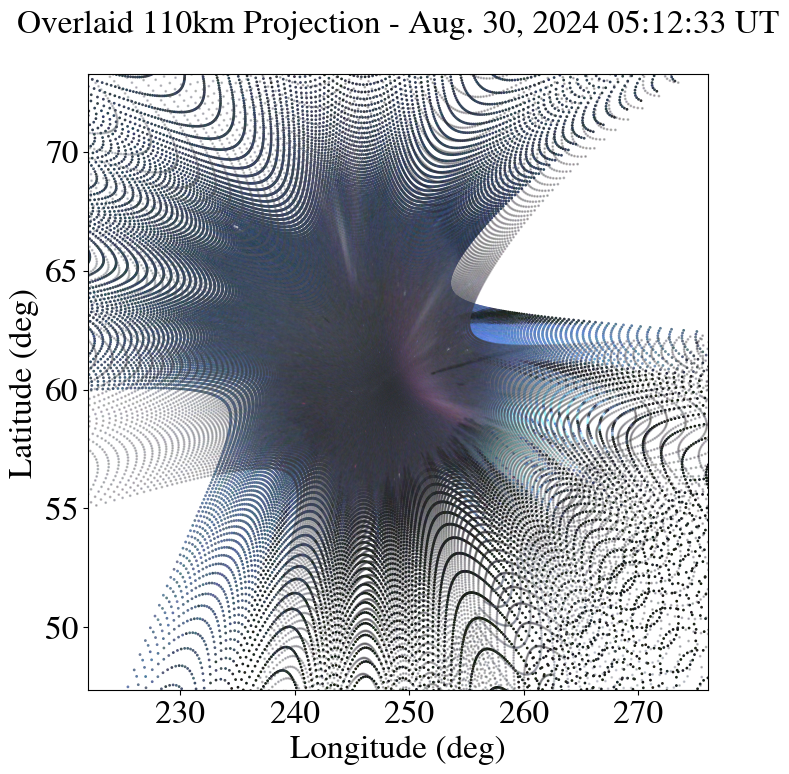

In [18]:
time_index = 251 # look at 5:10 UTC

R_yknf = yknf_rgb_asi_ds.image.sel(channel="R").isel(times=time_index).values
G_yknf = yknf_rgb_asi_ds.image.sel(channel="G").isel(times=time_index).values
B_yknf = yknf_rgb_asi_ds.image.sel(channel="B").isel(times=time_index).values

R_fsmi = fsmi_rgb_asi_ds.image.sel(channel="R").isel(times=time_index).values
G_fsmi = fsmi_rgb_asi_ds.image.sel(channel="G").isel(times=time_index).values
B_fsmi = fsmi_rgb_asi_ds.image.sel(channel="B").isel(times=time_index).values


# Extract time and format it
raw_time = yknf_rgb_asi_ds.times.values[time_index]
time_obj = pd.to_datetime(raw_time.decode("utf-8").replace(" UTC", ""))
time_str = time_obj.strftime("%b. %d, %Y %H:%M:%S UT")

site_name_yknf = "Yellowknife" 
site_name_fsmi = "Fort Smith" 

# contrast adjustment: alpha=contrast, beta=brightness
alpha = 5
beta = 5
rgb_yknf = np.stack([R_yknf, G_yknf, B_yknf], axis=-1)  # shape: (x, y, 3)
rgb_fsmi = np.stack([R_fsmi, G_fsmi, B_fsmi], axis=-1)  # shape: (x, y, 3)

rgb_yknf_adjusted = cv2.convertScaleAbs(rgb_yknf, alpha=alpha, beta=beta)
rgb_fsmi_adjusted = cv2.convertScaleAbs(rgb_fsmi, alpha=alpha, beta=beta)

# yknf projected
fig1, ax1 = plt.subplots(figsize=(8,8))
scat1 = ax1.scatter(yknf_lon_proj_110_arr.flatten(),yknf_lat_proj_110_arr.flatten(),c=rgb_yknf_adjusted.reshape(-1, 3)/256,s=1)
plt.xlim(ax_skymap.get_xlim())
plt.ylim(ax_skymap.get_ylim())
ax1.set_ylabel("Latitude (deg)")
ax1.set_xlabel("Longitude (deg)")
ax1.set_title(f"110km Projection: {site_name_yknf} – {time_str}", pad=30);
plt.show()

# fsmi projected
fig2, ax2 = plt.subplots(figsize=(8,8))
scat2 = ax2.scatter(fsmi_lon_proj_110_arr.flatten(),fsmi_lat_proj_110_arr.flatten(),c=rgb_fsmi_adjusted.reshape(-1, 3)/256,s=1)
plt.xlim(ax_skymap.get_xlim())
plt.ylim(ax_skymap.get_ylim())
ax2.set_ylabel("Latitude (deg)")
ax2.set_xlabel("Longitude (deg)")
ax2.set_title(f"110km Projection: {site_name_fsmi} – {time_str}", pad=30);
plt.show()

# 110km  overlaid --> 
plt.figure(figsize=(8,8))
plt.scatter(yknf_lon_proj_110_arr.flatten(),yknf_lat_proj_110_arr.flatten(),c=rgb_yknf_adjusted.reshape(-1, 3)/256,s=1, alpha=1)
plt.scatter(fsmi_lon_proj_110_arr.flatten(),fsmi_lat_proj_110_arr.flatten(),c=rgb_fsmi_adjusted.reshape(-1, 3)/256,s=1, alpha=0.3)
plt.xlabel("Longitude (deg)")
plt.ylabel("Latitude (deg)")
plt.title(f"Overlaid 110km Projection - {time_str}", pad=30)
plt.xlim(ax_skymap.get_xlim())
plt.ylim(ax_skymap.get_ylim())
plt.show()


### Look for outliers to see why plot looks like that

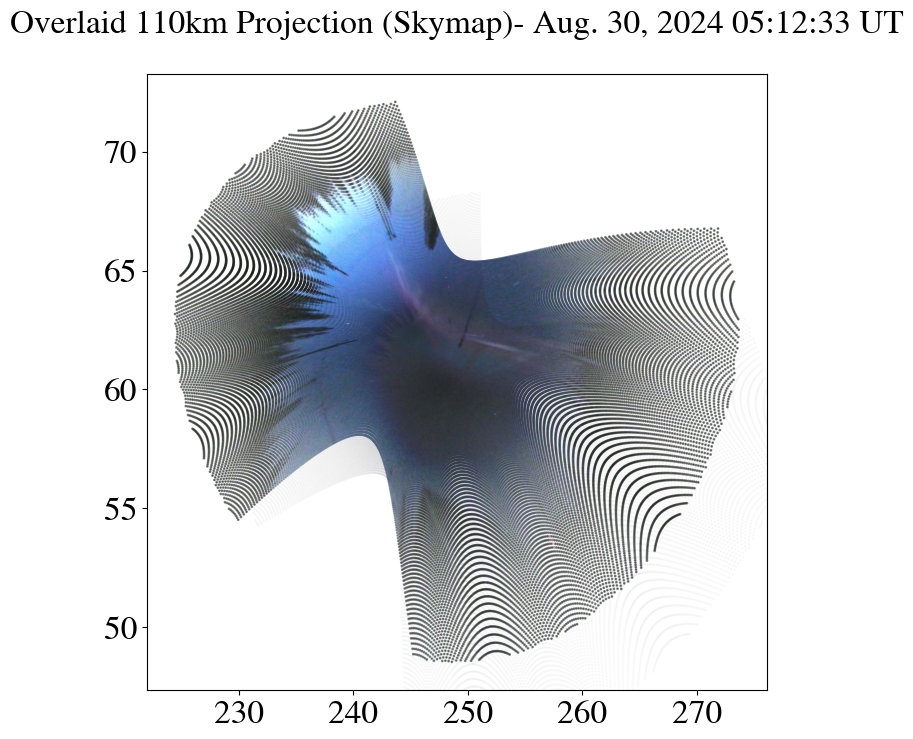

In [17]:
time_index = 251 # look at 5:10 UTC

R_yknf = yknf_rgb_asi_ds.image.sel(channel="R").isel(times=time_index).values
G_yknf = yknf_rgb_asi_ds.image.sel(channel="G").isel(times=time_index).values
B_yknf = yknf_rgb_asi_ds.image.sel(channel="B").isel(times=time_index).values

R_fsmi = fsmi_rgb_asi_ds.image.sel(channel="R").isel(times=time_index).values
G_fsmi = fsmi_rgb_asi_ds.image.sel(channel="G").isel(times=time_index).values
B_fsmi = fsmi_rgb_asi_ds.image.sel(channel="B").isel(times=time_index).values


# Extract time and format it
raw_time = yknf_rgb_asi_ds.times.values[time_index]
time_obj = pd.to_datetime(raw_time.decode("utf-8").replace(" UTC", ""))
time_str = time_obj.strftime("%b. %d, %Y %H:%M:%S UT")

site_name_yknf = "Yellowknife" 
site_name_fsmi = "Fort Smith" 

# contrast adjustment: alpha=contrast, beta=brightness
alpha = 5
beta = 5
rgb_yknf = np.stack([R_yknf, G_yknf, B_yknf], axis=-1)  # shape: (x, y, 3)
rgb_fsmi = np.stack([R_fsmi, G_fsmi, B_fsmi], axis=-1)  # shape: (x, y, 3)

rgb_yknf_adjusted = cv2.convertScaleAbs(rgb_yknf, alpha=alpha, beta=beta)
rgb_fsmi_adjusted = cv2.convertScaleAbs(rgb_fsmi, alpha=alpha, beta=beta)

# 110km overlaid (given projection)
yknf_lat_110_arr = np.array(yknf_rgb_asi_ds["lat_110"])
yknf_lon_110_arr = np.array(yknf_rgb_asi_ds["lon_110"])
fsmi_lat_110_arr = np.array(fsmi_rgb_asi_ds["lat_110"])
fsmi_lon_110_arr = np.array(fsmi_rgb_asi_ds["lon_110"])

plt.figure(figsize=(8,8))
plt.scatter(yknf_lon_110_arr.flatten(),yknf_lat_110_arr.flatten(),c=rgb_yknf_adjusted.reshape(-1, 3)/256,s=1, alpha=0.5)
plt.scatter(fsmi_lon_110_arr.flatten(),fsmi_lat_110_arr.flatten(),c=rgb_fsmi_adjusted.reshape(-1, 3)/256,s=1, alpha=0.02)
plt.xlim(ax_skymap.get_xlim())
plt.ylim(ax_skymap.get_ylim())
plt.title(f"Overlaid 110km Projection (Skymap)- {time_str}", pad=30)
ax2.set_ylabel("Latitude (deg)")
ax2.set_xlabel("Longitude (deg)")
ax2.set_title(f"Original Skymap {site_name_yknf} – {time_str}", pad=30);
plt.show()


# # 110km overlaid (my projection)
# plt.figure(figsize=(8,8))
# plt.scatter(yknf_lon_proj_110_arr.flatten(),yknf_lat_proj_110_arr.flatten(),c=rgb_yknf_adjusted.reshape(-1, 3)/256,s=1, alpha=1)
# plt.scatter(fsmi_lon_proj_110_arr.flatten(),fsmi_lat_proj_110_arr.flatten(),c=rgb_fsmi_adjusted.reshape(-1, 3)/256,s=1, alpha=0.3)
# plt.xlabel("Longitude (deg)")
# plt.ylabel("Latitude (deg)")
# plt.title("Overlaid 110km Projection - {time_str}", pad=30)
# plt.xlim(ax_skymap.get_xlim())
# plt.ylim(ax_skymap.get_ylim())
# plt.show()


don't expect steve to move too much in altitude, just in lat 
eventually -- algorithm for any given timestep, calculate what it thinks is most lilkely altitude, (see how stable it is to loop through all of them, reasonable based on lit)
more complicated -- 1 or several cuts thru image/steve, plot of intensity 
- intesnity as function along the cut, same lat/long for yknf and fsmi --> plot intensity along the cut
- what altitude when projected to, gives the most similar plots (to get optimal altitude at the center of the plots, not the extension, so just when STEVE is brightest) 